<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%203/Laboratorio_III_Soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




## Objetivos

*   Consolidar mediante la experimientación conceptos dados en clase en relación al algoritmo SVM.
*   Aplicación del algoritmo SVM para clasificación de imagenes.
*   Aplicación del proceso de aprendizaje a un caso de estudio.



# **Taller 3**

De acuerdo a los conceptos vistos en clase desarrolle el siguiente ejercicio práctico:

 1. El Internet de las Cosas (IoT) está desempeñando un papel cada vez más importante en nuestras actividades cotidianas, al habilitar la conexión de los objetos que nos rodean con servicios digitales. 
 
 Últimamente, IoT se ha visto afectado por una variedad de botnets, los cuales intentan explotar vulnerabilidades en los protocolos de aplicación que interactúan directamente con los sistemas, provocando violaciones de seguridad. 
 
 Una solución a este tipo de ataques es identificar, de manera automática, eventos maliciosos contra los protocolos de comunicación. En este sentido, ***se desea desarrollar un sistema de detección de intrusos que permita una identificación temprana de estas amenazas***. Sin embargo, el Departamento de Seguridad quiere identificar que ataque específico se está ejecutando para poder implementar los protocolos correspondientes.

Como recomendación general, se espera que para la entrega del taller se aplique la estructura establecida por la metodología CRISP- DM, según corresponda con las caracteristicas de cada conjunto de datos.

### **1. Importando las librerias requeridas para el desarrollo del laboratorio**

In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport


from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.compose import make_column_selector,  make_column_transformer

import matplotlib.pyplot as plt

import numpy as np
import warnings; warnings.simplefilter("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **2. Perfilamiento y entendimiento de los datos**

#### Lectura de los datos 

In [ ]:
url = 'https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%203/Punto%201/UNSW_NB15_training-set.csv'
train = pd.read_csv(url)
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


**Entendimientos de los datos**

Para ello, se utiliza pandas profiling.

In [ ]:
report = ProfileReport(train)
report.to_file('profile_report.html')

In [ ]:
from IPython.display import IFrame

IFrame(src='./profile_report.html', width=700, height=600)

In [ ]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

### **3. Limpieza y preparación de datos**

Para el análisis del modelo, se eliminan las variables de `id` y `label`, una por identificación y la otra debido a que queremos identificar especificamente el tipo de ataque, no saber si es un ataque o no.

Además, se realizan varios experimentos, uno eliminando los atributos , otra normalizando los datos y dejando los datos intactos.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class PositionalDrop(BaseEstimator, TransformerMixin):
    def __init__(self, positions=None):
        self.positions = positions

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.positions == None: return
        x_r = X.copy()
        return x_r.drop(self.positions,axis=1)

X = train.drop(['id','label','attack_cat'],axis=1)
Y = train['attack_cat']

### **4. Modelamiento**

In [ ]:
cat = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)))

norm = make_column_transformer(
       (MinMaxScaler(),
        make_column_selector(dtype_include=np.number)),  
       (OneHotEncoder(handle_unknown='ignore'),
        make_column_selector(dtype_include=object))) 


Creando pipeline de modelamiento

In [ ]:
estimators = [
              ('quitar', PositionalDrop()),
              ('transformar', norm), 
              ('clasificar', SVC(kernel='rbf',random_state=33,decision_function_shape='ovr',class_weight='balanced',cache_size=1024))
              ]
pipe = Pipeline(estimators)
param_grid = dict(
    quitar__positions=[None, ['sbytes','sloss','dbytes','dloss','is_sm_ips_ports','ct_srv_dst','ct_dst_sport_ltm',
                                      'ct_src_dport_ltm','ct_src_ltm']],
    transformar = [cat,norm],
    clasificar__gamma=[0.1,0.5,1],
    clasificar__C=[0.1,0.5,1],
    )

grid = GridSearchCV(pipe, param_grid=param_grid,verbose = 20,cv=5,n_jobs=-1)
grid.fit(X,Y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 19

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('quitar',
                                        PositionalDrop(positions=None)),
                                       ('transformar',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('minmaxscaler',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                  

### **5. Predicción**

In [ ]:
url = 'https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%203/Punto%201/UNSW_NB15_testing-set.csv'
test = pd.read_csv(url)
test.head()

X_test,Y_test = train.drop(['id','label','attack_cat'],axis=1), train['attack_cat']

model = grid.best_estimator_
y_pred = model.predict(X_test)
model

Pipeline(memory=None,
         steps=[('quitar',
                 PositionalDrop(positions=['sbytes', 'sloss', 'dbytes', 'dloss',
                                           'is_sm_ips_ports', 'ct_srv_dst',
                                           'ct_dst_sport_ltm',
                                           'ct_src_dport_ltm', 'ct_src_ltm'])),
                ('transformar',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(copy=True,
                                                               featur...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f91b1f12048>)],
                                   verbose=False)),
                ('clasificar',
  

### **6. Validación**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred, target_names=Y_test.unique()))

                precision    recall  f1-score   support

        Normal       0.13      0.16      0.14       677
Reconnaissance       0.14      0.75      0.23       583
      Backdoor       0.41      0.58      0.48      4089
           DoS       0.79      0.47      0.59     11132
      Exploits       0.36      0.57      0.44      6062
      Analysis       1.00      0.96      0.98     18871
       Fuzzers       0.98      0.72      0.83     37000
         Worms       0.38      0.45      0.41      3496
     Shellcode       0.05      0.66      0.09       378
       Generic       0.02      0.86      0.05        44

      accuracy                           0.71     82332
     macro avg       0.43      0.62      0.42     82332
  weighted avg       0.84      0.71      0.75     82332



Una forma alternativa de visualizar la matrix de confusión se presenta a continuación:

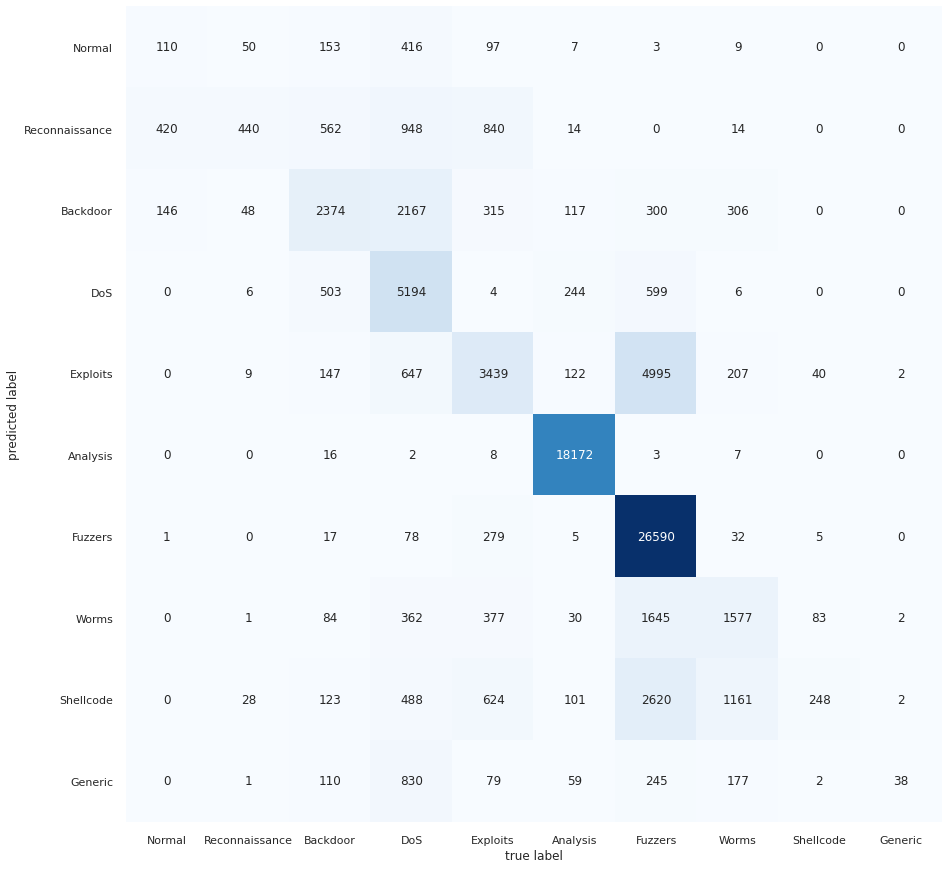

In [ ]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(Y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=Y_test.unique(),
            yticklabels=Y_test.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');